# Importar librerías 

In [1]:
import os
import cv2
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten


from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score

# Definición de los paths de los datos

In [4]:
# Ruta de datos de entrenamiento, testeo y validación del modelo
train_path = "data/128x128/train/"
test_path = "data/128x128/test/"
validation_path = "data/128x128/validation/"

img_size = (128, 128)
random.seed(1)

# Conversión de Imágenes a píxeles

negative


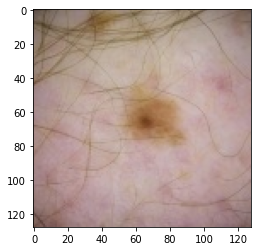

positive


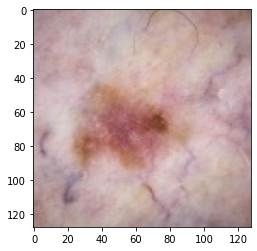

In [5]:
# función para mostrar 1 imágen aleatoria por clase 
for folder in os.listdir(train_path):
    sub_path = train_path + folder
    print(folder)
    for i in range(1):
        img_name = os.listdir(sub_path)[random.randrange(0, len(sub_path))]
        temp_path = sub_path + "/" + img_name
        img = mpimg.imread(temp_path)
        implot = plt.imshow(img)
        plt.show()


In [6]:
def image_to_array(path):
    data = []
    for folder in os.listdir(path):
        sub_path=path+"/"+folder

        for img in os.listdir(sub_path):
            image_path=sub_path+"/"+img
            img_arr=cv2.imread(image_path)
            data.append(img_arr)
            
    return data

In [7]:
train_data = image_to_array(train_path)
test_data = image_to_array(test_path)
validation_data = image_to_array(validation_path)

# Normaización 

In [8]:
x_train = np.array(train_data)/255
x_test = np.array(test_data)/255
x_validation = np.array(validation_data)/255

# Definición de las variables de entrada y salida

In [9]:
def data_class(data_path):
    data_generator = ImageDataGenerator(rescale=1.0/255,
                                        rotation_range=15,
                                        zoom_range=(0.15, 0.15), # zoom más pequeño
                                        horizontal_flip=True,
                                        vertical_flip=True)
    data_classes = data_generator.flow_from_directory(data_path,
                                                      target_size=(128, 128),
                                                      batch_size=32,
                                                      class_mode='sparse',
                                                      )
    return data_classes


In [10]:
train_class = data_class(train_path)
test_class = data_class(test_path)
validation_class = data_class(validation_path)

Found 8273 images belonging to 2 classes.
Found 1041 images belonging to 2 classes.
Found 1036 images belonging to 2 classes.


In [11]:
y_train = train_class.classes
y_test = test_class.classes
y_validation = validation_class.classes

In [12]:
train_class.class_indices

{'negative': 0, 'positive': 1}

# Creación del modelo VGG19

In [13]:
vgg19 = VGG19(input_shape=(128, 128, 3), 
              weights='imagenet',
              include_top=False, 
              )

In [14]:
for layer in vgg19.layers:
    layer.trainable = False

In [15]:
x = Flatten()(vgg19.output)
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg19.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [16]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [17]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=5)


In [18]:
train_vgg19 = model.fit(
    x_train,
    y_train,
    validation_data=(x_validation, y_validation),
    epochs=10,
    callbacks=[early_stop],
    batch_size=32,
    shuffle=True)


Epoch 1/10
259/259 [==============================] - 824s 3s/step - loss: 0.2340 - accuracy: 0.9367 - val_loss: 0.1963 - val_accuracy: 0.9421
Epoch 2/10
259/259 [==============================] - 709s 3s/step - loss: 0.1838 - accuracy: 0.9413 - val_loss: 0.1513 - val_accuracy: 0.9508
Epoch 3/10
259/259 [==============================] - 716s 3s/step - loss: 0.1772 - accuracy: 0.9439 - val_loss: 0.1561 - val_accuracy: 0.9488
Epoch 4/10
259/259 [==============================] - 728s 3s/step - loss: 0.1661 - accuracy: 0.9458 - val_loss: 0.1915 - val_accuracy: 0.9353
Epoch 5/10
259/259 [==============================] - 733s 3s/step - loss: 0.1523 - accuracy: 0.9469 - val_loss: 0.1496 - val_accuracy: 0.9498
Epoch 6/10
259/259 [==============================] - 729s 3s/step - loss: 0.1474 - accuracy: 0.9489 - val_loss: 0.1445 - val_accuracy: 0.9527
Epoch 7/10
259/259 [==============================] - 788s 3s/step - loss: 0.1628 - accuracy: 0.9465 - val_loss: 0.1686 - val_accuracy: 0.9353

# Visualización

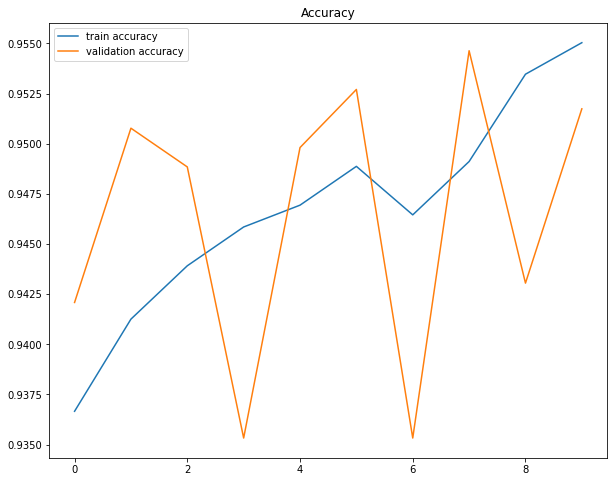

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(train_vgg19.history['accuracy'], label='train accuracy')
plt.plot(train_vgg19.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

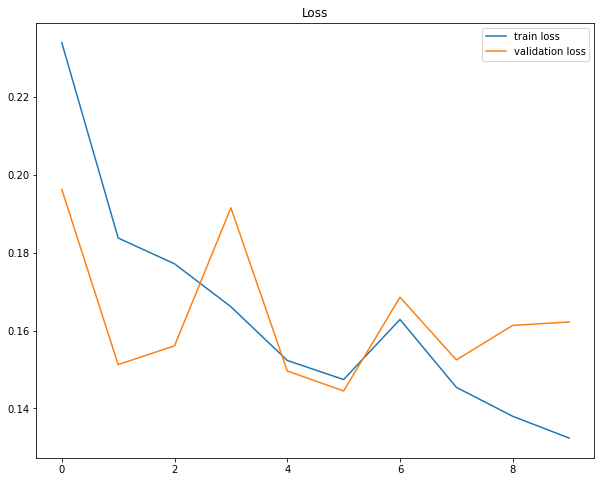

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(train_vgg19.history['loss'], label='train loss')
plt.plot(train_vgg19.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Loss')
plt.show()

# Evaluación del Modelo

In [23]:
model.evaluate(x_test, y_test, batch_size=32)

33/33 [==============================] - 123s 3s/step - loss: 0.1901 - accuracy: 0.9452


[0.19011753797531128, 0.9452449679374695]

In [24]:
y_pred = np.argmax(model.predict(x_test), axis=1)
print(classification_report(y_pred, y_test))


              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1032
           1       0.06      0.33      0.10         9

    accuracy                           0.95      1041
   macro avg       0.52      0.64      0.53      1041
weighted avg       0.99      0.95      0.96      1041



# Matriz de confusión

[Text(0, 0.5, 'Negativos'), Text(0, 1.5, 'Positivos')]

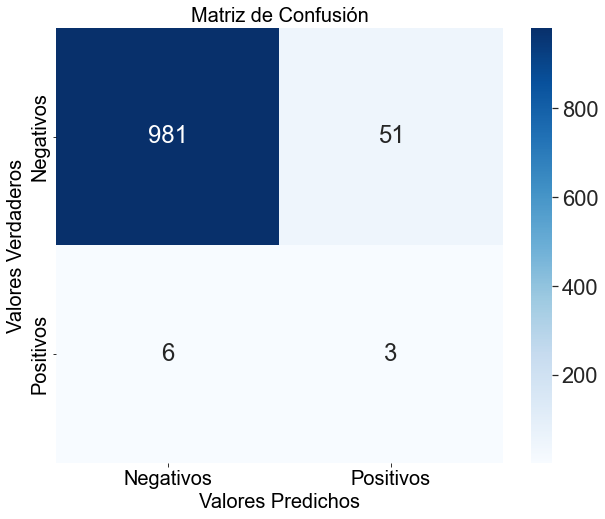

In [25]:
confusion = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(confusion, annot=True, fmt='g', cmap="Blues", ax=ax)

# labels, title and ticks
ax.set_xlabel('Valores Predichos', fontsize=20)
ax.set_ylabel('Valores Verdaderos', fontsize=20)
ax.set_title('Matriz de Confusión', fontsize=20)
ax.xaxis.set_ticklabels(['Negativos', 'Positivos'], fontsize=20)
ax.yaxis.set_ticklabels(['Negativos', 'Positivos'], fontsize=20)


In [26]:
f1_score(y_test, y_pred, average='micro')

0.9452449567723343

In [27]:
recall_score(y_test, y_pred, average='weighted')

0.9452449567723343

In [28]:
precision_score(y_test, y_pred, average='micro')

0.9452449567723343

# Guardar el modelo

In [29]:
model.save('./models/train_vgg19')

KeyboardInterrupt: 